# SHAP

## Ключевые концепции SHAP


**Значения Шепли:** SHAP вычисляет значение Шепли для каждого признака, представляющее его вклад в предсказание модели. Значение Шепли признака - это среднее предельное увеличение точности предсказания, которое включает этот признак, по всем возможным подмножествам других признаков.  

**Аддитивное объяснение:** SHAP основан на идее аддитивного объяснения, где объяснение модели представляет собой сумму вкладов каждого признака. Это позволяет SHAP обеспечить как локальные объяснения для отдельных предсказаний, так и глобальное понимание важности признаков.  

**Свойства объяснений:** Объяснения SHAP обладают несколькими желательными свойствами, включая локальную точность (объяснения соответствуют фактическому выходу модели для данного экземпляра), отсутствие смещения (вклады признаков в среднем равны разнице между фактическим предсказанием и средним предсказанием) и согласованность (увеличение значения признака никогда не должно уменьшать его вклад).  

**Методы аппроксимации:** Точный расчет значений Шепли может быть вычислительно сложным, особенно для моделей с большим количеством признаков. SHAP предлагает несколько методов аппроксимации, таких как Kernel SHAP (для любой модели), Linear SHAP (для линейных моделей), Tree SHAP (для деревьев решений и ансамблей) и Deep SHAP (для нейронных сетей), чтобы эффективно оценивать значения Шепли.

## Пример объяснения SHAP

1. **Признаки как игроки**: Представьте каждый признак в вашей модели как игрока в команде.

2. **Коалиция**: Коалиция — это любая комбинация игроков (признаков), работающих вместе.

3. **Измерение вклада игрока i**:
   - Сначала возьмите коалицию без игрока i
   - Запишите, какой результат (прогноз) даёт эта коалиция
   - Теперь добавьте игрока i к этой коалиции
   - Запишите новый результат с игроком i
   - Разница между этими двумя результатами — это вклад игрока i в эту конкретную коалицию

4. **Повторение для всех коалиций**: Проделайте шаг 3 для всех возможных коалиций, в которых может участвовать игрок i.

5. **Расчёт среднего вклада**: Усредните все полученные значения вклада игрока i по всем коалициям.

6. **Результат**: Полученное значение и есть SHAP значение для признака i, которое показывает, насколько в среднем этот признак повлиял на предсказание модели.

Этот подход справедливо распределяет "заслуги" между признаками и помогает понять, какие из них действительно важны для конкретного предсказания.

## Работа с моделью

Поработаем с бустингом и классическим датасетом [набором данных о жилье в Калифорнии](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html).  
Этот набор данных состоит из 20 640 блоков домов по всей Калифорнии в 1990 году, где наша цель - предсказать среднюю цену дома по 8 различным признакам:

### Описание данных

**Признаки:**

1. MedInc - медианный доход в районе
2. HouseAge - медианный возраст домов в районе
3. AveRooms - среднее количество комнат на домохозяйство
4. AveBedrms - среднее количество спален на домохозяйство
5. Population - население группы блоков
6. AveOccup - среднее количество членов домохозяйства
7. Latitude - широта района
8. Longitude - долгота района

**Целевая переменная:**

- MedHouseVal - средняя стоимость домов в районе


In [1]:
import os

import matplotlib
import shap
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
X, y = shap.datasets.california()

Как прежде — сразу обучим модель на имеющихся данных. Однако, в этот раз мы пропускаем процесс нормализации признаков.

**Quiz 1: Почему процесс нормализации может быть опущен?**

In [4]:
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

model = GradientBoostingRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=4, 
    random_state=random_state
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(r2_score(y_test, y_pred))

0.8067886209624695


# SHAP и анализ прогнозов обучeнной модели

## Локальная интерпретация

### Force Plot Explanation

**Force plot** - это график, который наглядно показывает, как каждый признак влияет на предсказание модели.

**Что показывает этот график:**
- Базовое значение - среднее предсказание модели на всех данных
- Как каждый признак "толкает" предсказание вверх (красным) или вниз (синим) от базового значения
- Итоговое предсказание - результат всех этих "толчков"

Force plot помогает понять, какие именно характеристики объекта и насколько сильно повлияли на конкретное предсказание модели. Например, почему модель предсказала высокую стоимость именно этого дома или высокую вероятность отклика именно этого клиента.

In [5]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

Посмотрим на прогнозы для 10-го строчки

In [6]:
example = shap_values[10, :]

In [7]:
y_pred_example = model.predict(X_train)[10]
print(y_pred_example)

1.7531620914165262


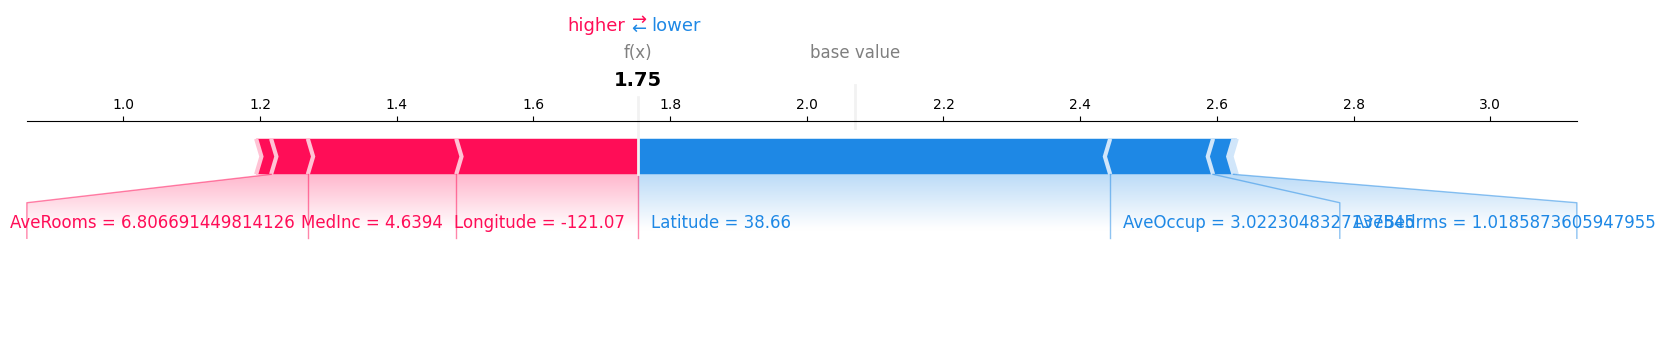

In [8]:
shap.plots.force(example, matplotlib=matplotlib)

### Ограничение Force Plot и его решение

Основной недостаток графика `force_plot` заключается в том, что он не показывает точные числовые значения вкладов Шепли для каждого признака. Это затрудняет количественную оценку влияния признаков на предсказание модели.

К счастью, для получения более детальной информации можно использовать `waterfall_plot`, который наглядно демонстрирует те же самые вклады признаков, но с указанием конкретных числовых значений.

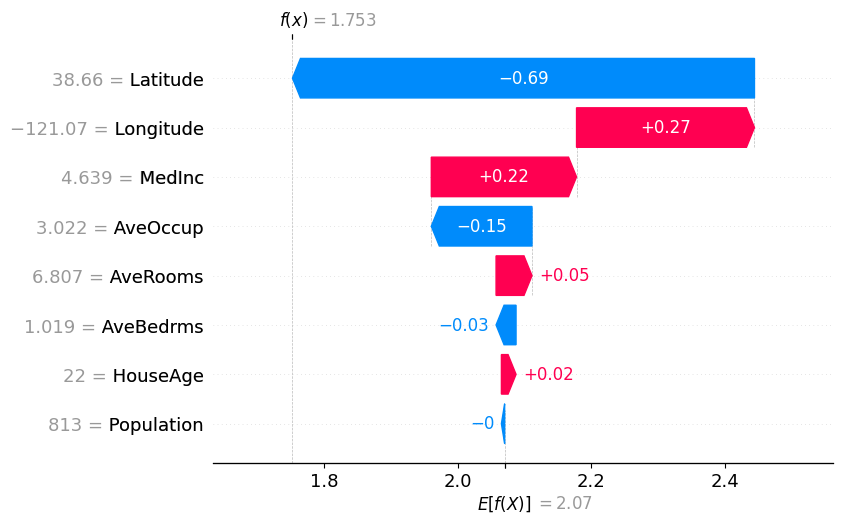

In [9]:
shap.plots.waterfall(example, max_display=8)

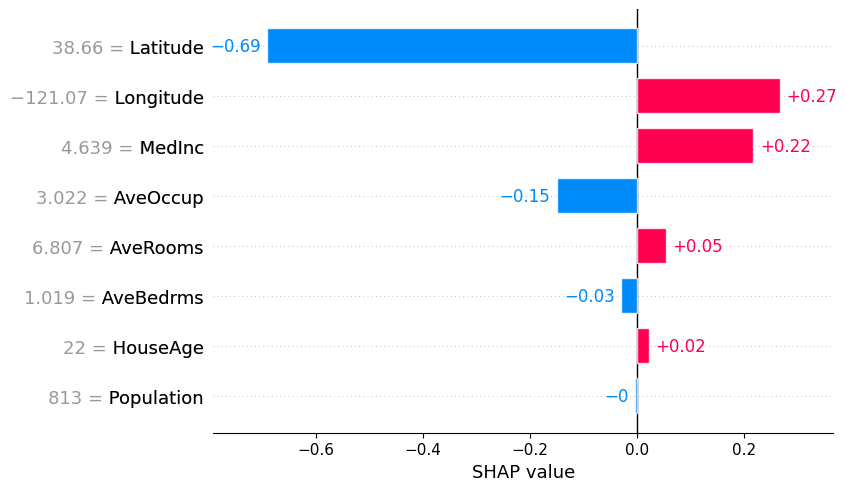

In [10]:
shap.plots.bar(example, max_display=8)

## Глобальная интерпретация

### Влияние отдельного признака

In [11]:
examples = shap_values[:100]

In [16]:
# используем версию shap==0.46.0
shap.initjs()
shap.plots.force(examples)

Выбирая конкретные признаки для осей X и Y, мы можем легко увидеть, как определенный признак влияет на предсказания модели для всего набора данных.

Например, если выбрать "MedInc effects" (влияние среднего дохода) и "MedInc" (значения среднего дохода), график покажет, что:
- В некоторых случаях высокий средний доход увеличивает предсказание модели (положительный эффект)
- В других случаях тот же признак может уменьшать предсказание (отрицательный эффект)

Это помогает понять зависимость между значением признака и его влиянием на результат модели.

## Влияние нескольких признаков

### Взаимодействие признаков (Feature Interaction)

Дальше мы можем исследовать, как признаки взаимодействуют между собой, влияя на результат. Это называется *feature interaction*.

**Другими словами:**
- Это когда влияние одного признака на прогноз зависит от значения другого признака
- Два признака вместе дают эффект, который отличается от суммы их отдельных эффектов

**Пример:**
Представьте, что мы анализируем цены на жилье:
- Большая площадь обычно увеличивает цену дома
- Но этот эффект может быть гораздо сильнее для новых домов, чем для старых
- То есть "площадь" и "возраст дома" взаимодействуют между собой при формировании цены

Такие взаимодействия важно обнаруживать, чтобы лучше понимать, как работает модель.

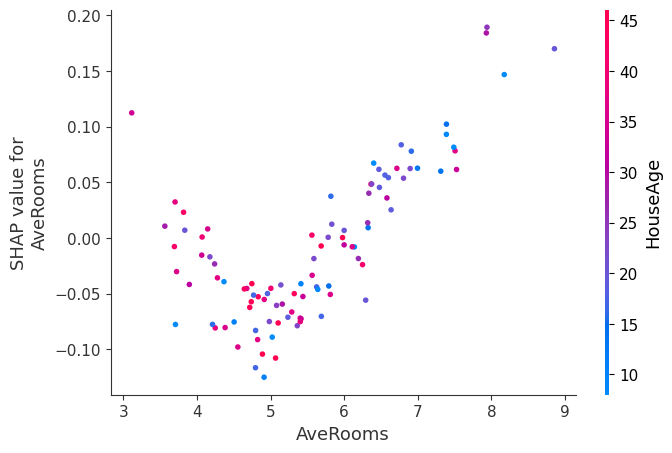

In [17]:
shap.dependence_plot("AveRooms", shap_values.values[:100], X_train[:100], interaction_index="HouseAge")

## Как читать график взаимодействия признаков

**Что показывают оси графика:**

- **Левая шкала (вертикальная ось)** - показывает значения Шепли, то есть силу влияния признаков на прогноз. Важно обращать внимание на диапазон значений, чтобы правильно понять график.

- **Правая и нижняя шкалы** - показывают значения двух признаков, взаимодействие которых мы изучаем.

**Пример интерпретации:**
Если рассматривать взаимодействие возраста дома и количества комнат, важно смотреть на тренд целиком. Может показаться, что у старых домов малое количество комнат снижает цену, но на самом деле график говорит: чем старше дом, тем меньше влияние количества комнат на его стоимость.

## Beeswarm

Давайте посмотрим на общую картину - какой в среднем вклад вносит каждый признак в итоговый прогноз.

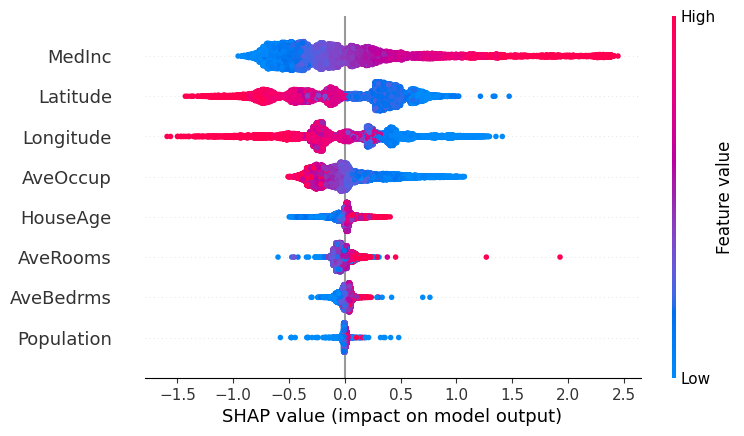

In [18]:
shap.plots.beeswarm(shap_values)

### Что показывает нам этот график:

Этот график помогает понять, как в целом каждый признак влияет на прогноз модели:

- **Расположение дома** (ширина и долгота): когда эти значения увеличиваются, стоимость дома обычно снижается
- **Медианный доход района**: более высокий доход в районе значительно повышает стоимость домов
- **Население района** (Population): даже большие значения почти не влияют на прогноз цены
- **Среднее число спален**: оказывает небольшое влияние на стоимость дома

Такой анализ помогает определить, какие факторы действительно важны для предсказания цен на недвижимость.

### Bar Plot

Другой способ показать общую важность признаков - это столбчатая диаграмма. Важно отметить, что здесь используется среднее значение абсолютной величины (модуля) коэффициентов Шепли, поэтому мы видим только силу влияния, но не его направление (положительное или отрицательное).

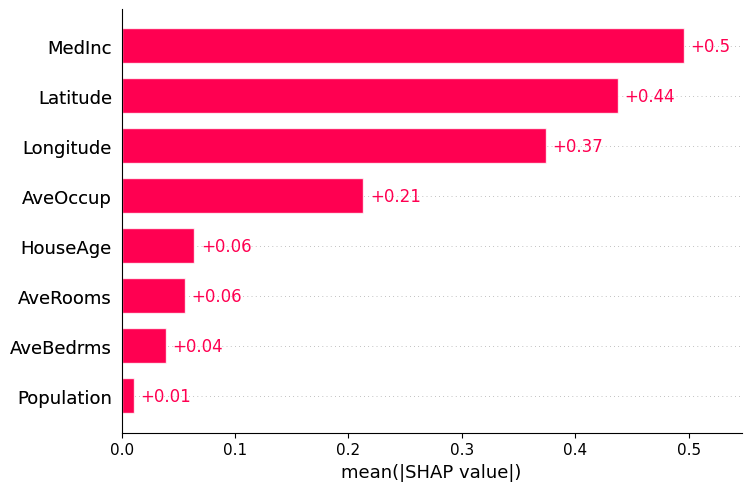

In [19]:
shap.plots.bar(shap_values)